In [216]:
import nltk
nltk.download('punkt_tab')
import os
import random
nltk.download('punkt')
import pandas as pd
import numpy as np
import torch
from collections import defaultdict
from sklearn.svm import SVC
import json
import re
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [217]:
database = pd.read_excel('train_4452.xlsx')
database.tail(10)

,Unnamed: 0,title,body,date,tags,source,target
4442,4443,no title,Такой вот был позитивный сентимент вокруг акци...,2021-11-22 13:55:28+00:00,сбер,https://t.me/MarketDumki,0
4443,4444,no title,"По Газпрому похожая ситуация сегодня, что и в ...",2021-11-22 14:17:18+00:00,газпром,https://t.me/MarketDumki,-1
4444,4445,no title,"Акции Газпрома хоть и снижаются сегодня на 3%,...",2021-11-26 13:12:44+00:00,газпром,https://t.me/MarketDumki,0
4445,4446,no title,Еще в пятницу на падении рынка была видна поку...,2021-11-29 17:18:50+00:00,газпром,https://t.me/MarketDumki,1
4446,4447,no title,"Оставлю скрин на память. В ""стакане"" Газпрома ...",2021-12-14 04:40:12+00:00,газпром,https://t.me/MarketDumki,-1
4447,4448,no title,Красноречивые обороты сегодня в Сбере. 72 млрд...,2022-01-14 14:03:01+00:00,газпром,https://t.me/MarketDumki,0
4448,4449,no title,​​По Сберу сформировался очень сильный уровень...,2022-01-17 19:56:42+00:00,сбер,https://t.me/MarketDumki,0
4449,4450,no title,"​​Чем дальше в лес, тем больше дров! Сегодня о...",2022-01-18 19:19:44+00:00,сбер,https://t.me/MarketDumki,-1
4450,4451,no title,На протяжении многих лет не один раз на рынке ...,2022-02-25 08:34:58+00:00,сбер,https://t.me/MarketDumki,-1
4451,4452,no title,"На фоне того, сколько сейчас стОят акции Сбера...",2022-03-01 10:35:00+00:00,сбер,https://t.me/MarketDumki,-1


In the dataset the disclamers of the souces entities , and not needed quater marks are noticed . So they are deleted. Words and punctuation were saved. We also preserve the case of the source text

In [218]:
def preprocess(s):
    # function for text clearning
    s=s.replace('no title','')
    s=s.replace('no tags','')
    s=s.replace('[]','')
    s=s.split('$$$ БКС Мир инвестиций $$$ Инвестировать легче вместе')[0]
    s=s.replace('$$$','.')
    s=re.sub('\s*"','',s)
    s=s.replace('#','')
    s=s.replace(' • ',', ')
    return s


In [219]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(database, test_size=0.2, random_state=42)

In [220]:
train['text_extraction'] = train.title + ' ' + train.body + ' ' + train.tags
train['text_extraction_cleaned']= train.text_extraction.map(preprocess)
train['text_extraction_cleaned'][0]

" Самолет (SMLT) в 4кв2023 собирается побить рекорд 3кв. Менеджмент подтверждает цель в 1 600 тыс. кв. м продаж за весь 2023 год. аналитика факты Видимо, менеджмент видит уже по октябрьским цифрам, что даже после роста ключевой ставки продажи на первичке идут хорошо. Первичный рынок, особенно массовый сегмент, на котором работает Самолет — бенефициар программ льготной ипотеки. Цель на год 1600 кв.м.:, по итогам 9 месяцев есть 973 тыс. кв. м., консолидация МИЦ даст примерно 100 тыс. кв. м, таким образом, продажи Самолёта без МИЦ в 4 квартале могут составить порядка 527 тыс. кв. м - на 25% больше, чем в рекордном 3кв2023. ['аналитика', 'факты']"

In [221]:
train['text_extraction_cleaned'][0]

" Самолет (SMLT) в 4кв2023 собирается побить рекорд 3кв. Менеджмент подтверждает цель в 1 600 тыс. кв. м продаж за весь 2023 год. аналитика факты Видимо, менеджмент видит уже по октябрьским цифрам, что даже после роста ключевой ставки продажи на первичке идут хорошо. Первичный рынок, особенно массовый сегмент, на котором работает Самолет — бенефициар программ льготной ипотеки. Цель на год 1600 кв.м.:, по итогам 9 месяцев есть 973 тыс. кв. м., консолидация МИЦ даст примерно 100 тыс. кв. м, таким образом, продажи Самолёта без МИЦ в 4 квартале могут составить порядка 527 тыс. кв. м - на 25% больше, чем в рекордном 3кв2023. ['аналитика', 'факты']"

## Dataset analysis 

Basic statistics :

In [222]:
def words(i):
    # a function for splitting text into words
    regex = re.compile(r'[А-Яа-яA-zёЁ-]+')
    i= " ".join(regex.findall(i))
    tokens=word_tokenize(i.lower())
    return tokens

In [223]:
train['tokens'] = train.text_extraction_cleaned.map(words)


In [224]:
example_number = train.shape[0]


mean_length_text_extract=[]
for i in train.tokens:
    mean_length_text_extract.append(len(i))
mean_length_text_extract=np.mean(mean_length_text_extract)

number_unique_words=set()
for i in train.tokens:
    for j in i:
        number_unique_words.add(j)
number_unique_words=len(number_unique_words)

print('Checking the number of missing values : ' )
print(f'Number of missing values  in text_extraction: {train.text_extraction_cleaned.isnull().sum()}',f'Number of missing values in assessment of tonality : {train.target.isnull().sum()}','',sep='\n')
print(f'Number of examples in dataset: {example_number}','',sep='\n' )

print(f'Mean length of text_extraction: {round(mean_length_text_extract,0)}','',sep='\n')

print(f'Number of unique words : {number_unique_words}')

Checking the number of missing values : 
Number of missing values  in text_extraction: 0
Number of missing values in assessment of tonality : 0

Number of examples in dataset: 3561

Mean length of text_extraction: 73.0

Number of unique words : 30615


Target column analysis

In [225]:
def year_extraction(s):
    # function for year extraction from the date column
    if type(s) == int or type(s) == float:
       s=str(s)
    else:
       s=s.split('-')[0]
    return int(s)

In [232]:
# preparing train dataset to embedding extraction
sentences_train = train.text_extraction_cleaned.values
labels_train = train.target.values
sentences_train[1]

' ВТБ, ао (VTBR) ПОКУПАТЬ Инвестиционный горизонт 2-6 мес. Цена входа 0,034 руб. Цель 0,039 руб. Потенциальная доходность на сделку 14,7% Объём входа 16,2% Стоп приказ 0,0319 руб. Бумага торгуется в восходящем тренде, встретив сопротивление в районе 0,037 р. Мы рекомендуем открывать длинные позиции на уровне 0,034 р., при откате от текущего уровня в 0,035 р. При покупке на 16,2% от портфеля и выставлении стоп заявки на 0,0319 р., риск на портфель составит 1%. Соотношение прибыль/риск составляет 2,38. Чистая прибыль ВТБ за первый квартал составила 38,9 млрд. рублей, снизившись на 6,7 млрд. рублей по сравнению с аналогичным периодом прошлого года. Основным негативным фактором послужила переоценка непрофильных активов банка. Прим этом чистые комиссионные доходы за первый квартал выросли на 48,1%. Одним из важных пунктов стратегии банка является повышение уровня цифровизации бизнеса, что окажет положительное влияние на операционную эффективность. Смотрите также: Macy’s Inc. (М) ПОКУПАТЬhtt

In [233]:
# preparing test dataset to embedding extraction
test['text_extraction'] = test.title + ' ' + test.body + ' ' + test.tags
test['text_extraction_cleaned']= test.text_extraction.map(preprocess)


In [234]:
sentences_test = test.text_extraction_cleaned.values
labels_test = test.target.values
sentences_test[0]

' СД ТМК одобрил размещение замещающих облигаций '

## Repeating the experiment with the best parameters to analyse errors and save the model:

Support Functions:

In [235]:
def flatten_accuracy(preds, labels):
    # function that calculates accuracy for Bert model
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def flatten_f1_score(preds, labels):
    # function that calculates F1 Score for Bert model
    preds_flat = np.argmax(preds, axis = 1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='macro')


Data preparation:

In [236]:
# import tokenizer for BERT model
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

In [237]:
batch_size = 8
max_length=round(mean_length_text_extract,0)
max_length=int(max_length)
max_length

73

In [238]:
# prepare labels for the model
def index_change_labels(s):
   # a function that changes the value of labels to indexes that are understandable to BertForClassification model
    if s == 1 :
       s=0
    elif s== 0:
       s=1
    elif s== -1:
       s=2
    return s

train['index_BERT']= train.target.map(index_change_labels)
labels_train= train.index_BERT.values
labels_train

array([2, 0, 2, ..., 0, 2, 2])

In [239]:
input_ids = []
attention_masks = []

for sent in sentences_train:
    encoded_dict = tokenizer.encode_plus(
                        sent,
                        add_special_tokens = True,
                        max_length = max_length,
                        pad_to_max_length = True,
                        return_attention_mask = True,
                        return_tensors = 'pt',
                   )

    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels_train)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2673: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [240]:
print('Original: ', sentences_train[3])
print('Token IDs:', input_ids[3])

Original:   Обзор финансовых показателей Алросы 2 кв2019 Автор подробно разобрал отчет и ответил на вопросстоит ли покупать прямо сейчас? https://smart-lab.ru/blog/556933.php алроса
Token IDs: tensor([   101,  18890,  48645,    561,  13139, 109751,  12861,  45899,  13594,
         21859,  26657,  44181,  10292,    123,  69055,  22650,  54055,  28433,
         11429,  14315,  40671,  17257,  33276,  31326,  10332,  54697,    549,
         83415,  13460,  10122,  58099,  41054,  15811,  33190,  10297,  86613,
         18235,  75552,  61149,    136,  14120,    131,    120,    120,  98507,
           118,  93409,    119,  13483,    120,  31907,    120,  54919,  11373,
         69646,    119,  13417,  21720,  44181,  10179,    102,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0])


In [241]:
# devide to train and validation set in proportion 90% vs 10%
from torch.utils.data import TensorDataset, random_split

dataset = TensorDataset(input_ids, attention_masks, labels)


train_size = int(0.9 * len(dataset))
dev_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, dev_size])

print(f'{train_size} training samples')
print(f'{dev_size} validation samples')

3204 training samples
357 validation samples


In [242]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler


train_dataloader = DataLoader(
            train_dataset,
            sampler = RandomSampler(train_dataset),
            batch_size = batch_size,drop_last=True
        )

validation_dataloader = DataLoader(
            val_dataset,
            sampler = SequentialSampler(val_dataset),
            batch_size = batch_size,drop_last=True
        )


In [243]:
# preparing data for test set
test['index_BERT']= test.target.map(index_change_labels)
labels_test= test.index_BERT.values
labels_test


input_ids = []
attention_masks = []

for sent in sentences_test:
    encoded_dict = tokenizer.encode_plus(
                        sent,
                        add_special_tokens = True,
                        max_length = max_length,
                        pad_to_max_length = True,
                        return_attention_mask = True,
                        return_tensors = 'pt',
                   )

    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels_test)


prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2673: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Model inizialization:

In [244]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

model = BertForSequenceClassification.from_pretrained('bert-base-multilingual-cased',num_labels = 3,output_attentions = False,output_hidden_states = False)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [245]:
# inicialization of the model
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    model.cuda()
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

In [246]:
# Set an optimizer

def set_optimizer(lr = 2e-5, dft_rate=1.2, correct_bias=True, eps = 1e-8, discriminative= True):
      # discrimination rate is governed by dft_rate in discriminative fine-tuning
      no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight'] #  weights will not be applied to the parameters whose names include these tokens.


      if discriminative == True:

                encoder_params = []
                for i in range(12):
                    encoder_decay = {
                        'params': [p for n, p in list(model.bert.encoder.layer[i].named_parameters()) if
                                  not any(nd in n for nd in no_decay)],
                        'weight_decay': 0.01,
                        'lr': lr / (dft_rate ** (12 - i))}
                    encoder_nodecay = {
                        'params': [p for n, p in list(model.bert.encoder.layer[i].named_parameters()) if
                                  any(nd in n for nd in no_decay)],
                        'weight_decay': 0.0,
                        'lr': lr / (dft_rate ** (12 - i))}
                    encoder_params.append(encoder_decay)
                    encoder_params.append(encoder_nodecay)

                optimizer_grouped_parameters = [
                    {'params': [p for n, p in list(model.bert.embeddings.named_parameters()) if
                                not any(nd in n for nd in no_decay)],
                    'weight_decay': 0.01,
                    'lr': lr / (dft_rate ** 13)},
                    {'params': [p for n, p in list(model.bert.embeddings.named_parameters()) if
                                any(nd in n for nd in no_decay)],
                    'weight_decay': 0.0,
                    'lr': lr / (dft_rate ** 13)},
                    {'params': [p for n, p in list(model.bert.pooler.named_parameters()) if
                                not any(nd in n for nd in no_decay)],
                    'weight_decay': 0.01,
                    'lr': lr},
                    {'params': [p for n, p in list(model.bert.pooler.named_parameters()) if
                                any(nd in n for nd in no_decay)],
                    'weight_decay': 0.0,
                    'lr': lr},
                    {'params': [p for n, p in list(model.classifier.named_parameters()) if
                                not any(nd in n for nd in no_decay)],
                    'weight_decay': 0.01,
                    'lr': lr},
                    {'params': [p for n, p in list(model.classifier.named_parameters()) if any(nd in n for nd in no_decay)],
                    'weight_decay': 0.0,
                    'lr': lr}]

                optimizer_grouped_parameters.extend(encoder_params)


      else:
                param_optimizer = list(model.named_parameters())

                optimizer_grouped_parameters = [
                    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
                    'weight_decay': 0.01},
                    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
                ]

      return AdamW(optimizer_grouped_parameters,
                    lr=lr,
                    eps = eps,
                    correct_bias=correct_bias)

In [247]:
from transformers import get_linear_schedule_with_warmup

# set sheduler

def set_scheduler (train_dataloader,epochs,optimizer, STLR = True) :
    total_steps = len(train_dataloader) * epochs
    if STLR == True:
       warm_up_proportion=0.1
       num_warmup_steps = int(float(total_steps) * warm_up_proportion)
    else:
       num_warmup_steps=0
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = num_warmup_steps,num_training_steps = total_steps)
    return scheduler

In [248]:
from sklearn.metrics import accuracy_score,f1_score

# training the model
import random

def train(model,train_dataloader,validation_dataloader,optimizer,scheduler,device,epochs=4,seed_val=42,gradual_unfreeze=True,encoder_no=1):

    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


    if torch.cuda.is_available():
        torch.cuda.manual_seed(42)
        torch.cuda.manual_seed_all(42)

    training_stats = []
    i=0
    step_number = len(train_dataloader)
    for epoch_i in range(0, epochs):
        print(f'Epoch {epoch_i} : ')
        # Reset the total loss for this epoch.
        total_train_loss = 0
        model.train()
        for step, batch in enumerate(train_dataloader):

            # graduate unfrizing
            if (gradual_unfreeze and i == 0):
                for param in model.bert.parameters():
                    param.requires_grad = False
            if (step % (step_number // 3)) == 0:
                i += 1
            if (gradual_unfreeze and i > 1 and i < encoder_no):
                for k in range(i - 1):
                    try:
                        for param in model.bert.encoder.layer[encoder_no - 1 - k].parameters():
                            param.requires_grad = True
                    except:
                        pass
            if (gradual_unfreeze and i > encoder_no + 1):
                for param in model.bert.embeddings.parameters():
                    param.requires_grad = True

            #main loop
            if step % 10 == 0 and not step == 0:
                # Report progress.
                print(' Epoch {:>5,}  Batch {:>5,}  of  {:>5,}.   '.format(epoch_i,step, len(train_dataloader)))

            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels=batch[2].to(device)

            model.zero_grad()


            output = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask,labels=b_labels)
            loss = output[0]
            logits = output[1]


            total_train_loss += loss.item()
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()


        avg_train_loss = total_train_loss / len(train_dataloader)

        print("")
        print("  Average training loss: {0:.2f}".format(avg_train_loss))



        print("")
        print("Validation:")

        model.eval()

        total_eval_accuracy = 0
        total_eval_loss = 0
        total_f1 =0
        nb_eval_steps = 0

        for batch in validation_dataloader:

            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels=batch[2].to(device)

            with torch.no_grad():
                output = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask,labels=b_labels)
                loss = output[0]
                logits = output[1]



            total_eval_loss += loss.item()
            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()

            total_eval_accuracy += flatten_accuracy(logits, label_ids)
            total_f1+=flatten_f1_score(logits, label_ids)

        # Report the final accuracy for this validation run.
        avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
        print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

        # Calculate the average loss over all of the batches.
        avg_val_loss = total_eval_loss / len(validation_dataloader)

        print("  Validation Loss: {0:.2f}".format(avg_val_loss))

        # Calculate the average F1 over all of the batches.
        avg_val_f1 = total_f1 / len(validation_dataloader)

        print("  Validation F1: {0:.2f}".format(avg_val_f1),'',sep='\n')

        training_stats.append(
        {
            'Epoch': epoch_i + 1,
            'Train. Loss': round(avg_train_loss,2),
            'Valid. Loss': round(avg_val_loss,2),
            'Valid. Accur.': round(avg_val_accuracy,2),
            'Valid. F1': round(avg_val_f1,2),
            'Number_of_epochs': epochs,
        }
        )

    return model,training_stats


In [249]:
# Prediction on the Test set
def evaluation(model,prediction_dataloader,tokenizer):

      valid_stats=[]
      model.eval()
      Full_test_set=[]

      predictions , true_labels , text = [], [] ,[]

      # Predict
      for batch in prediction_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        with torch.no_grad():
            outputs = model(b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask)

        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Store predictions and true labels
        predictions.append(logits)
        true_labels.append(label_ids)
        for i in b_input_ids:
            string_seg= tokenizer.decode(i,skip_special_tokens=True)
            text.append(string_seg)



      from sklearn.metrics import accuracy_score

      flat_predictions = np.concatenate(predictions, axis=0)
      flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
      flat_true_labels = np.concatenate(true_labels, axis=0)

      valid_stats.append(
        {
            'Accuracy': round(accuracy_score(flat_true_labels, flat_predictions),2),
            'F1 Score': round(f1_score(flat_true_labels, flat_predictions, average='macro'),2)

        }
        )

      print("Metrics for Test set: ")
      print("Accuracy: ", round(accuracy_score(flat_true_labels, flat_predictions),2))
      print("F1 Score: ", round(f1_score(flat_true_labels, flat_predictions, average='macro'),2),'',sep='\n')

      Full_test_set.append(
        {
            'True_labels': flat_true_labels.reshape(-1, 1),
            'Predicted_labels': flat_predictions.reshape(-1, 1),
            'Text': np.transpose(text)


        }
        )

      return Full_test_set

In [250]:
# Repiting Best Experiment

for epochs in [2]:
      print ('Number of epochs :',epochs)

      # domain train model (with decay, STLR )

      name='model with Decay,SLTR'

      optimizer = set_optimizer(lr = 2e-5,eps = 1e-8, discriminative= False)
      scheduler=set_scheduler(train_dataloader,epochs,optimizer,STLR = True)

      model_D_SLTR, result_D_SLTR = train(model,train_dataloader,validation_dataloader,optimizer,scheduler,device,epochs=epochs,gradual_unfreeze=False)


Number of epochs : 2
Epoch 0 : 


/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


 Epoch     0  Batch    10  of    400.   
 Epoch     0  Batch    20  of    400.   
 Epoch     0  Batch    30  of    400.   
 Epoch     0  Batch    40  of    400.   
 Epoch     0  Batch    50  of    400.   
 Epoch     0  Batch    60  of    400.   
 Epoch     0  Batch    70  of    400.   
 Epoch     0  Batch    80  of    400.   
 Epoch     0  Batch    90  of    400.   
 Epoch     0  Batch   100  of    400.   
 Epoch     0  Batch   110  of    400.   
 Epoch     0  Batch   120  of    400.   
 Epoch     0  Batch   130  of    400.   
 Epoch     0  Batch   140  of    400.   
 Epoch     0  Batch   150  of    400.   
 Epoch     0  Batch   160  of    400.   
 Epoch     0  Batch   170  of    400.   
 Epoch     0  Batch   180  of    400.   
 Epoch     0  Batch   190  of    400.   
 Epoch     0  Batch   200  of    400.   
 Epoch     0  Batch   210  of    400.   
 Epoch     0  Batch   220  of    400.   
 Epoch     0  Batch   230  of    400.   
 Epoch     0  Batch   240  of    400.   
 Epoch     0  Ba

In [251]:
dataset_test_with_pred=evaluation(model=model_D_SLTR,prediction_dataloader=prediction_dataloader,tokenizer=tokenizer)

Metrics for Test set: 
Accuracy:  0.63
F1 Score: 
0.62



In [252]:
def index_change_labels_reverse(s):
   # a function that changes the value of labels to indexes that are understandable to BertForClassification model
    if s == 0 :
       s=1
    elif s== 1:
       s=0
    elif s== 2:
       s=-1
    return s

In [253]:
df_stats = pd.DataFrame (data=dataset_test_with_pred)
df_stats
df_stats1 = pd.DataFrame (df_stats['True_labels'][0],columns=['True_labels'])
df_stats3 = pd.DataFrame (df_stats['Predicted_labels'][0],columns=['Predicted_labels'])
df_stats2 = pd.DataFrame (df_stats['Text'][0],columns=['Text'])
df_stats=pd.concat([df_stats1,df_stats3,df_stats2],axis=1)

df_stats['True_labels']=df_stats['True_labels'].map(index_change_labels_reverse)
df_stats['Predicted_labels']=df_stats['Predicted_labels'].map(index_change_labels_reverse)
df_stats.to_excel('pred_test.xlsx',index=False)
df_stats.head(5)

,True_labels,Predicted_labels,Text
0,1,0,СД ТМК одобрил размещение замещающих облигаций
1,-1,-1,Результаты за полугодие продолжают давить на к...
2,0,0,Фундаментальный анализ Григорий Богданов Добры...
3,0,0,Сезон отпусков закончился и теперь мы можем ви...
4,-1,1,Мы сохраняем умеренно - позитивный взгляд на а...


In [254]:
test=test.reset_index()
test.to_excel('test.xlsx',index=False)
test.head(5)

,index,Unnamed: 0,title,body,date,tags,source,target,text_extraction,text_extraction_cleaned,index_BERT
0,807,808,no title,СД ТМК одобрил размещение замещающих облигаций,2023-11-01,no tags,smart_lab,1,no title СД ТМК одобрил размещение замещающих ...,СД ТМК одобрил размещение замещающих облигаций,0
1,443,444,no title,"""​​ Результаты за полугодие продолжают давить ...",2024-09-02,['отчет'],t_invest,-1,"no title ""​​ Результаты за полугодие продолжаю...",​​ Результаты за полугодие продолжают давить н...,2
2,3361,3362,no title,Фундаментальный анализ Григорий Богданов Добры...,2019-09-30 18:33:04+00:00,фосагро,https://t.me/smartlabnews,0,no title Фундаментальный анализ Григорий Богда...,Фундаментальный анализ Григорий Богданов Добр...,1
3,2114,2115,no title,Сезон отпусков закончился и теперь мы можем ви...,2020-10-06 07:01:28+00:00,озон,https://t.me/russianmacro,0,no title Сезон отпусков закончился и теперь мы...,Сезон отпусков закончился и теперь мы можем в...,1
4,2510,2511,no title,Мы сохраняем умеренно-позитивный взгляд на акц...,2021-01-25 10:06:48+00:00,нлмк,https://t.me/finamalert,-1,no title Мы сохраняем умеренно-позитивный взгл...,Мы сохраняем умеренно-позитивный взгляд на ак...,2


Mapping predictions of the model made on test dataset   with full test dataset:

In [255]:
full_stats=df_stats.join(test)
# saving the test datset with predicted labels for future use 
full_stats.to_excel('full_stats.xlsx',index=False)
full_stats

,True_labels,Predicted_labels,Text,index,Unnamed: 0,title,body,date,tags,source,target,text_extraction,text_extraction_cleaned,index_BERT
0,1,0,СД ТМК одобрил размещение замещающих облигаций,807,808,no title,СД ТМК одобрил размещение замещающих облигаций,2023-11-01,no tags,smart_lab,1,no title СД ТМК одобрил размещение замещающих ...,СД ТМК одобрил размещение замещающих облигаций,0
1,-1,-1,Результаты за полугодие продолжают давить на к...,443,444,no title,"""​​ Результаты за полугодие продолжают давить ...",2024-09-02,['отчет'],t_invest,-1,"no title ""​​ Результаты за полугодие продолжаю...",​​ Результаты за полугодие продолжают давить н...,2
2,0,0,Фундаментальный анализ Григорий Богданов Добры...,3361,3362,no title,Фундаментальный анализ Григорий Богданов Добры...,2019-09-30 18:33:04+00:00,фосагро,https://t.me/smartlabnews,0,no title Фундаментальный анализ Григорий Богда...,Фундаментальный анализ Григорий Богданов Добр...,1
3,0,0,Сезон отпусков закончился и теперь мы можем ви...,2114,2115,no title,Сезон отпусков закончился и теперь мы можем ви...,2020-10-06 07:01:28+00:00,озон,https://t.me/russianmacro,0,no title Сезон отпусков закончился и теперь мы...,Сезон отпусков закончился и теперь мы можем в...,1
4,-1,1,Мы сохраняем умеренно - позитивный взгляд на а...,2510,2511,no title,Мы сохраняем умеренно-позитивный взгляд на акц...,2021-01-25 10:06:48+00:00,нлмк,https://t.me/finamalert,-1,no title Мы сохраняем умеренно-позитивный взгл...,Мы сохраняем умеренно-позитивный взгляд на ак...,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,1,1,"Благодаря вчерашним событиям, консервативный п...",3606,3607,no title,"​​Благодаря вчерашним событиям, консервативный...",2020-02-12 07:40:31+00:00,новатэк,https://t.me/finrangecom,1,"no title ​​Благодаря вчерашним событиям, консе...","​​Благодаря вчерашним событиям, консервативны...",0
887,-1,1,"На фоне того, сколько сейчас стОят акции Сбера...",4451,4452,no title,"На фоне того, сколько сейчас стОят акции Сбера...",2022-03-01 10:35:00+00:00,сбер,https://t.me/MarketDumki,-1,"no title На фоне того, сколько сейчас стОят ак...","На фоне того, сколько сейчас стОят акции Сбер...",2
888,0,1,В 4 квартале 2023 года рентабельность X5 по EB...,240,241,no title,В 4 квартале 2023 года рентабельность X5 по EB...,2024-03-21,no tags,smart_lab,0,no title В 4 квартале 2023 года рентабельность...,В 4 квартале 2023 года рентабельность X5 по E...,1
889,0,0,По словам зампреда правления Сбербанка Станисл...,3105,3106,no title,По словам зампреда правления Сбербанка Станисл...,2022-03-23 15:14:52+00:00,сбер,https://t.me/banksta,0,no title По словам зампреда правления Сбербанк...,По словам зампреда правления Сбербанка Станис...,1


## Analysing the errors of the model: 

In [256]:
full_stats = pd.read_excel('full_stats.xlsx')
df_stats = pd.read_excel('pred_test.xlsx')


In [257]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(df_stats['True_labels'], df_stats['Predicted_labels'],labels=[1,0,-1])
cm

array([[226,  74,  41],
       [ 73, 182,  73],
       [ 38,  35, 149]])

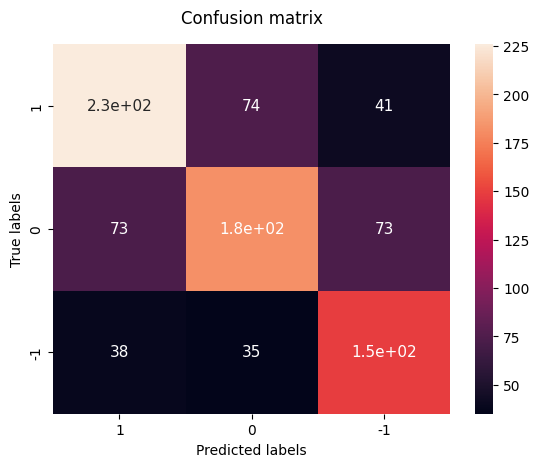

In [258]:
import seaborn as sns

x_axis_labels = [1, 0, -1]
y_axis_labels = [1, 0, -1]
sns.heatmap(cm, annot=True, annot_kws={'fontsize': 11},xticklabels=x_axis_labels, yticklabels=y_axis_labels,)

plt.ylabel('True labels')
plt.xlabel('Predicted labels')
plt.title('Confusion matrix', pad=15)
plt.show()

In [269]:
df_stats_err = df_stats[(df_stats['True_labels']==0)& (df_stats['Predicted_labels']==1)]
df_stats_err

,True_labels,Predicted_labels,Text
11,0,1,Сбербанк. Вероятно протестирует нижнюю границу...
31,0,1,РОССИЙСКИЙ РЫНОК ИТОГИ ТОРГОВ : В среднесрочно...
47,0,1,Производственные результаты Лукойл за 1 полуго...
51,0,1,Компания : ЛУКОЙЛ Событие : Изменение размера ...
55,0,1,Фиксирую свой лонг по Роснефти - цель была 335...
...,...,...,...
852,0,1,Газпром заказал максимальный объем транзита га...
872,0,1,ПАО Сбербанк ( SBER ) ПОКУПАТЬ Авторские права...
878,0,1,"Коммерческие запасы нефти в США за неделю + 0,..."
879,0,1,Платежи Северстали ( CHMF ) по экспортным пошл...


## Saving the model:

In [267]:
print("Saving model to ./model_save/")

model_D_SLTR.save_pretrained('./model_save/')
tokenizer.save_pretrained('./model_save/')


Saving model to ./model_save/


('./model_save/tokenizer_config.json',
 './model_save/special_tokens_map.json',
 './model_save/vocab.txt',
 './model_save/added_tokens.json')